In [4]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
#from collections import Counter
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import scipy.stats as stats
from Bio import SeqIO, AlignIO, pairwise2
#from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace, EvolTree

# yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")

# if yeast_esr_flag=='Y':
#     yeast_esr_exp_path = os.path.normpath('C:/Users/heineib/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
#     #io_library_path_core = io_library_path + 'core' + os.sep
#     if not(yeast_esr_exp_path in sys.path):
#         sys.path.append(yeast_esr_exp_path)
#         print("Added " + yeast_esr_exp_path + " to path" )
#     import yeast_esr_exp
#     yeast_esr_exp.base_dir = yeast_esr_exp_path
#     yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep
    
base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Make alignment that will allow visualization of the Jalview tree
gois = ['CDC19']
og_refs = {'CDC19': 'OG1299_REF_Scer_AF-P00549-F1-model_v2' , 
           'HSU1': 'OG1390_REF_Scer_AF-P47164-F1-model_v2'
          }

#gois = ['COR1', 'QCR2', 'COX5A_COX5B']  #COR1 is also called QCR1

for goi in gois: 
    og_ref = og_refs[goi] #'OG1122_REF_Scer_AF-P13711-F1-model_v2'
    print('{}: {}'.format(goi,og_ref))
    orig_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
    jalview_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed_jalview/' + og_ref + '.tm.fasta')

    orig_aln = SeqIO.parse(orig_aln_fname, 'fasta')

    with open(jalview_aln_fname,'w') as f_out:
        for record in orig_aln: 
            f_out.write('>' + record.id + '\n')
            f_out.write(str(record.seq) + '\n')

CDC19: OG1299_REF_Scer_AF-P00549-F1-model_v2


In [57]:
#Conservation data is in
scores_mapped = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Mapped.tsv'), index_col = 0)
params_to_plot_mapped = ['Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]', 'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]']
scores_mapped_subset = scores_mapped.loc[:,params_to_plot_mapped]

scores_exp = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Experimental.tsv'), index_col = 0)#
params_to_plot_exp = ['Mean(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]','Std(log2(Abundances)) 10 Sp [EXP]','1k_Mean_log2_Abundances [EXP]']
scores_exp_subset = scores_exp.loc[:,params_to_plot_exp]

scores_data = scores_mapped_subset.merge(scores_exp_subset, how = 'outer', left_index=True, right_index=True)

#Load my YN00 Data

#dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'), index_col=0)  #This had a dS filter at 3.  We should use the data with the filter at 10
dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_maxdS_10.csv'), index_col=0)

#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )

#Load Nielsen Lab files 
dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]
dnds_nl_with_SCE.drop(columns = 'OG', inplace=True)
dnds_nl_with_SCE.rename(columns= {'dN_dS': 'dN_dS_nielsen_SCE'}, inplace=True)

dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]
dnds_nl_03_02.drop(columns = 'OG', inplace=True)
dnds_nl_03_02.rename(columns= {'dN_dS': 'dN_dS_nielsen_03_02'}, inplace=True)
                         
#merge structural data with m0 data
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)
dnds_struct_data = dnds_m0_for_merge.merge(scores_data, how='outer', left_index=True, right_index=True)

#merge yn00 data
yn00_col_rename = {col:col +'_yn00' for col in dnds_yn00.columns}
dnds_yn00_for_merge = dnds_yn00.rename(columns = yn00_col_rename)
dnds_struct_data = dnds_struct_data.merge(dnds_yn00_for_merge, how='outer', left_index=True, right_index=True)
dnds_struct_data['og_ref'] = dnds_struct_data.index

#Merge nielsen lab data
dnds_struct_data = dnds_struct_data.merge(dnds_nl_with_SCE, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data = dnds_struct_data.merge(dnds_nl_03_02, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data.set_index('og_ref', inplace=True)


#Load ETC_proteins_clustered data
etc_proteins_clustered = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)


In [58]:
#Pick Example Proteins.  
#  ETC Proteins
#  Pox2
#  Cdc19

example_proteins = {'COX5AB': 'OG4316_REF_Scer_AF-P00424-F1-model_v2', 
                    'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2', 
                    'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
                    'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
                    'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
                    'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2', 
                    'COX7': 'OG4346_REF_Scer_AF-P10174-F1-model_v2', 
                    'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2', 
                    'CDC19': 'OG1299_REF_Scer_AF-P00549-F1-model_v2',
                    'POX1': 'OG1122_REF_Scer_AF-P13711-F1-model_v2'
                   }



In [10]:
list(example_proteins.values())

['OG4316_REF_Scer_AF-P00424-F1-model_v2',
 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
 'OG1299_REF_Scer_AF-P00549-F1-model_v2',
 'OG1122_REF_Scer_AF-P13711-F1-model_v2']

In [59]:
dnds_struct_data.loc[list(example_proteins.values()), :]

,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,convergence_issue_m0,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],...,Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP],og_yn00,dN_dS_struct_yn00,dN_struct_yn00,dS_struct_yn00,dN_dS_nielsen_SCE,og_x,dN_dS_nielsen_03_02,og_y
og_ref,,,,,,,,,,,,,,,,,,,,,
OG4316_REF_Scer_AF-P00424-F1-model_v2,OG4316,35.393291,1.27410,0.13305,4.5792,34.4183,False,0.534953,0.117073,0.681956,...,1.089781,8.014961,OG4316,0.1780,0.48220,3.11190,0.21000,OG4316,0.2262,OG4316
OG2248_REF_Scer_AF-P07143-F1-model_v2,OG2248,36.063606,1.26135,0.04297,1.7977,41.8418,False,0.820567,0.045392,0.895618,...,0.869077,8.867480,OG2248,0.0555,0.14760,3.77730,0.04620,OG2248,0.0513,OG2248
OG3575_REF_Scer_AF-P08067-F1-model_v2,OG3575,24.577237,1.33301,0.07590,2.0340,26.7988,False,0.780641,0.048762,0.862761,...,0.932915,7.729029,OG3575,0.0676,0.17625,3.41290,0.06580,OG3575,0.0787,OG3575
OG2006_REF_Scer_AF-P07257-F1-model_v2,OG2006,85.816195,1.26877,0.07908,6.9683,88.1218,False,0.489216,0.141572,0.650761,...,1.132876,9.476601,OG2006,0.2039,0.64680,3.11570,0.19990,OG2006,0.1860,OG2006
OG4352_REF_Scer_AF-P00127-F1-model_v2,OG4352,33.684114,1.43708,0.06460,2.6508,41.0328,False,0.487109,0.135934,0.603246,...,NaN,NaN,OG4352,0.1215,0.30900,2.73980,0.09240,OG4352,0.1186,OG4352
OG2714_REF_Scer_AF-P00427-F1-model_v2,OG2714,70.812619,1.10652,0.02549,2.3920,93.8539,False,0.790822,0.073056,0.871323,...,1.115466,8.758464,OG2714,0.0959,0.24390,3.13410,0.07765,OG2714,0.0473,OG2714
OG4346_REF_Scer_AF-P10174-F1-model_v2,OG4346,33.166247,1.21921,0.12753,4.1819,32.7902,False,0.555262,0.154441,0.710824,...,NaN,NaN,OG4346,0.2059,0.45045,2.53065,0.21395,OG4346,0.2280,OG4346
OG4751_REF_Scer_AF-P04039-F1-model_v2,OG4751,53.763429,1.36766,0.07465,4.4849,60.0766,False,0.574850,0.142711,0.740749,...,NaN,7.699653,OG4751,0.2018,0.35120,1.89300,0.16090,OG4751,0.1554,OG4751
OG1299_REF_Scer_AF-P00549-F1-model_v2,OG1299,35.541141,1.33863,0.08320,3.1528,37.8925,False,0.758158,0.053904,0.853132,...,2.395779,15.117014,OG1299,0.0606,0.19590,4.11265,0.07960,OG1299,0.1723,OG1299


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


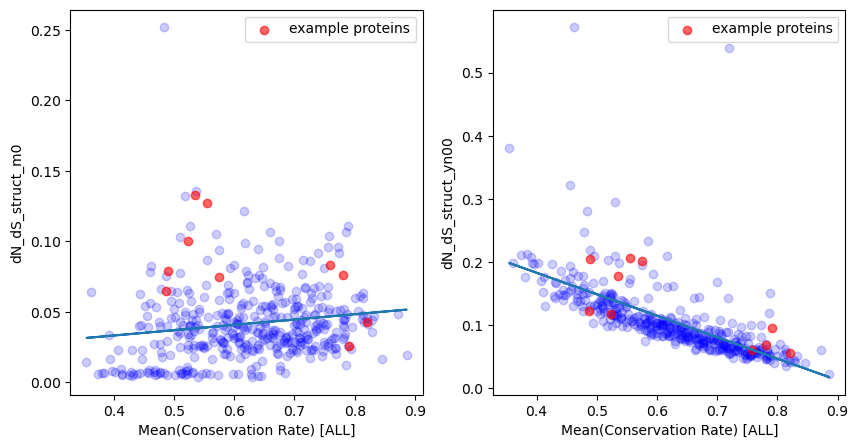

In [60]:
#plot YN00 and M0 vs Abundance
fig, axarr = plt.subplots(1,2, figsize=(10,5))

#xlim = (-0.2,1.2)

y_values = ['dN_dS_struct_m0', 'dN_dS_struct_yn00'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'Mean(Conservation Rate) [ALL]' #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, y_value in enumerate(y_values): 
    ax = axarr[jj]
    
    dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
    dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')
    
    #dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
    #dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 
      
    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()
    
    #add linear regression line to scatterplot 
    x_data = dnds_struct_data[x_value]
    y_data = dnds_struct_data[y_value]
    
    na_filt = x_data.notna() & y_data.notna()
    
    x_data = x_data[na_filt]
    y_data = y_data[na_filt]
    
    #m, b = np.polyfit(x_data, y_data, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    ax.plot(list(x_data), list(slope*x_data+intercept))
    #ax.plot(x_data,x_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


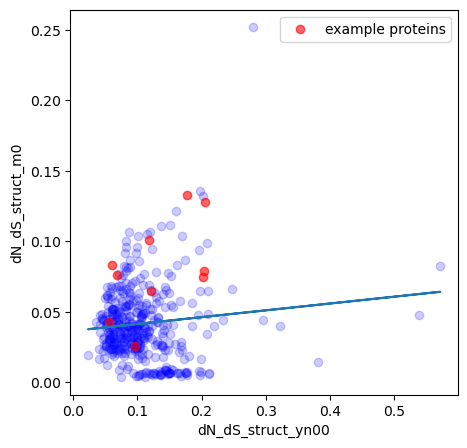

In [61]:
#plot YN00 and M0 vs Abundance
fig, ax = plt.subplots(1,1, figsize=(5,5))

#xlim = (-0.2,1.2)

y_value = 'dN_dS_struct_m0'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dN_dS_struct_yn00' #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')

#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = dnds_struct_data[x_value]
y_data = dnds_struct_data[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
#ax.plot(x_data,x_data)

In [ ]:
#Make 100% trimmed alignment for example proteins

In [16]:
a = dnds_struct_data[x_value].loc[dn_ds_]

og_ref
OG1004_REF_Scer_AF-P15938-F1-model_v2                  True
OG1004_REF_Scer_AF-P20095-F1-model_v2                 False
OG1004_REF_Scer_AF-P24384-F1-model_v2                 False
OG1004_REF_Scer_AF-P40459-F1-model_v2                  True
OG1004_REF_Scer_AF-P53131-F1-model_v2                 False
                                                      ...  
OG6065_kluyveromyces_marxianus__OG6065__51_1934       False
OG6290_vanderwaltozyma_polyspora__OG6290__136_4191    False
OG6574_kluyveromyces_marxianus__OG6574__51_629        False
OG6598_kluyveromyces_marxianus__OG6598__51_2377       False
OG7278_kazachstania_naganishii__OG7278__49_2415       False
Length: 543, dtype: bool

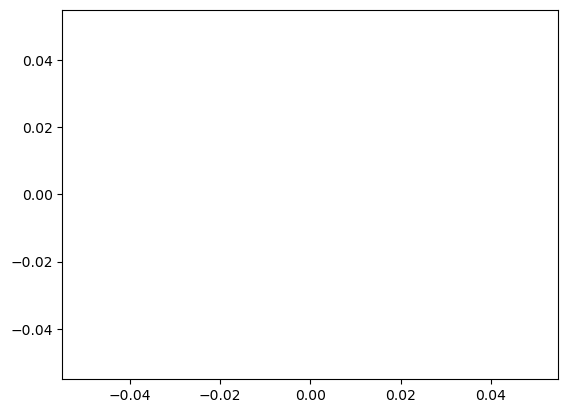

In [23]:
fig, ax = plt.subplots()
plt.scatter(x_data,slope*x_data+intercept)

In [21]:
x_data

og_ref
OG1004_REF_Scer_AF-P15938-F1-model_v2                 0.493276
OG1004_REF_Scer_AF-P20095-F1-model_v2                 0.498909
OG1004_REF_Scer_AF-P24384-F1-model_v2                 0.527397
OG1004_REF_Scer_AF-P40459-F1-model_v2                 0.549115
OG1004_REF_Scer_AF-P53131-F1-model_v2                 0.568291
                                                        ...   
OG6065_kluyveromyces_marxianus__OG6065__51_1934            NaN
OG6290_vanderwaltozyma_polyspora__OG6290__136_4191         NaN
OG6574_kluyveromyces_marxianus__OG6574__51_629             NaN
OG6598_kluyveromyces_marxianus__OG6598__51_2377            NaN
OG7278_kazachstania_naganishii__OG7278__49_2415            NaN
Name: Mean(Conservation Rate) [ALL], Length: 543, dtype: float64

In [15]:
#Check M0 with my trimming vs M0 with the same strict trimming as YN00

#Make complete trimming in 
#20231110_struct_align_dnds_msas_full_trim.sh which calls
#20231110_struct_align_dnds_msas_full_trim.py

#Rerun M0 with 
#20231110_run_m0_complete_trim.sh

#Extract M0 values

#Extract DN/DS values from M0 calculations
m0_base =  base_dir + os.sep + os.path.normpath('selection_calculations/m0_complete_trim/') + os.sep
m0_data_df = dyt.load_m0_data(m0_base)
m0_data_df.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_complete_trim/m0.csv'))

m0_col_rename = {col : col + '_m0_complete_trim' for col in m0_data_df.columns}
m0_data_df = m0_data_df.rename(columns = m0_col_rename)

#Causes two OGs to get convergence issues that didn't have them before: 
#convergence issue in OG2714_REF_Scer_AF-P00427-F1-model_v2
#convergence issue in OG4346_REF_Scer_AF-P10174-F1-model_v2

convergence issue in OG2714_REF_Scer_AF-P00427-F1-model_v2
convergence issue in OG4346_REF_Scer_AF-P10174-F1-model_v2


In [16]:
m0_data_df

,og_m0_complete_trim,tree_length_m0_complete_trim,kappa_m0_complete_trim,dN_dS_struct_m0_complete_trim,tree_length_dN_m0_complete_trim,tree_length_dS_m0_complete_trim,convergence_issue_m0_complete_trim
OG4316_REF_Scer_AF-P00424-F1-model_v2,OG4316,39.824510,1.23377,0.11399,4.5453,39.8754,False
OG2248_REF_Scer_AF-P07143-F1-model_v2,OG2248,36.119648,1.31555,0.04070,1.6994,41.7551,False
OG3575_REF_Scer_AF-P08067-F1-model_v2,OG3575,23.601598,1.36160,0.07140,1.8242,25.5484,False
OG2006_REF_Scer_AF-P07257-F1-model_v2,OG2006,81.900092,1.30163,0.08027,6.7601,84.2169,False
OG4352_REF_Scer_AF-P00127-F1-model_v2,OG4352,30.517332,1.48632,0.06532,2.4096,36.8895,False
OG2714_REF_Scer_AF-P00427-F1-model_v2,OG2714,79.124124,1.13244,0.02085,2.2063,105.8096,True
OG4346_REF_Scer_AF-P10174-F1-model_v2,OG4346,34.955817,1.22837,0.11615,4.0700,35.0403,True
OG4751_REF_Scer_AF-P04039-F1-model_v2,OG4751,38.495534,1.18220,0.09623,3.9594,41.1447,False
OG1299_REF_Scer_AF-P00549-F1-model_v2,OG1299,35.060411,1.37420,0.07057,2.7005,38.2671,False
OG1122_REF_Scer_AF-P13711-F1-model_v2,OG1122,60.249491,1.15830,0.09324,6.1540,66.0025,False


In [17]:
example_m0_orig = dnds_struct_data.loc[list(example_proteins.values()), :]
example_m0_merged = example_m0_orig.merge(m0_data_df, left_index = True, right_index = True, how = 'inner')

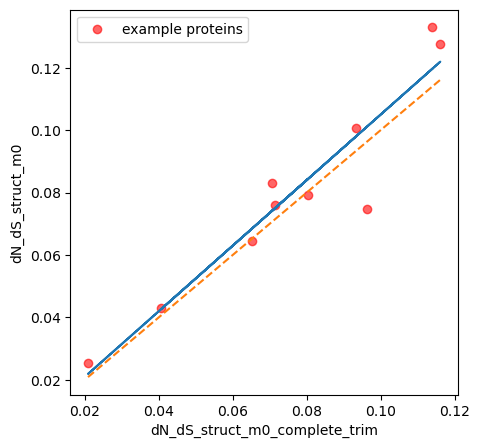

In [21]:
#plot YN00 and M0 vs Abundance
fig, ax = plt.subplots(1,1, figsize=(5,5))

#xlim = (-0.2,1.2)

y_value = 'dN_dS_struct_m0'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dN_dS_struct_m0_complete_trim' #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (example_m0_merged.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
#dnds_foreground = (dnds_struct_data.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
#dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(example_proteins.values())), :], 'b', 0.2,'')

#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_foreground]:  #dnds_background, 
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = example_m0_merged[x_value]
y_data = example_m0_merged[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--')
#ax.plot(x_data,x_data)

In [ ]:
# YN00 has a range of values.  It also has a DS filter for values above 3 that seems inappropriate for our data.

In [3]:
example_proteins

{'COX5AB': 'OG4316_REF_Scer_AF-P00424-F1-model_v2',
 'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
 'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
 'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
 'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
 'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
 'COX7': 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
 'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
 'CDC19': 'OG1299_REF_Scer_AF-P00549-F1-model_v2',
 'POX1': 'OG1122_REF_Scer_AF-P13711-F1-model_v2'}

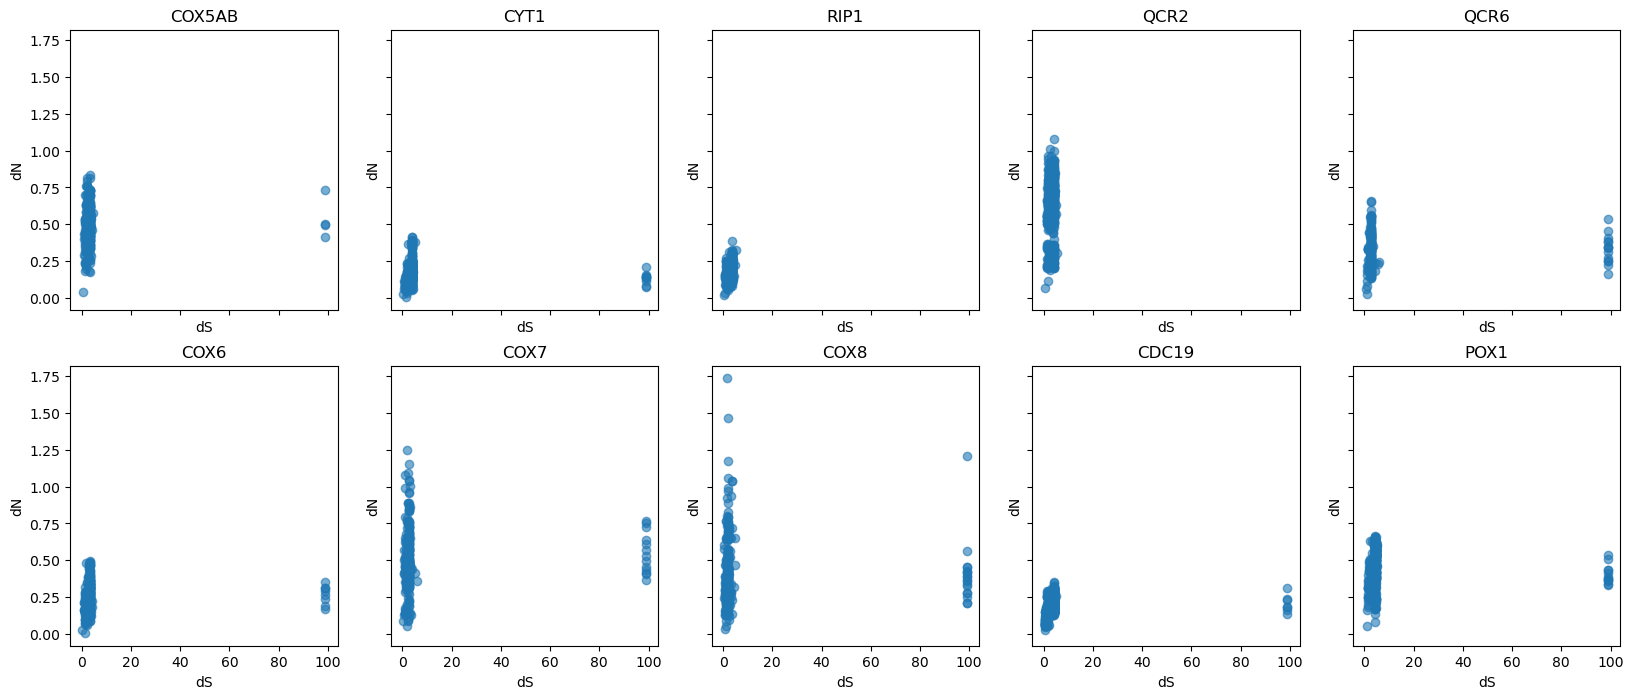

In [17]:
# og_name = 'QCR2'
# og_ref = example_proteins['QCR2']

fig, axarr = plt.subplots(2,5, figsize = (20,8), sharex=True, sharey = True)
axarr_flat = axarr.flatten()


for jj, (og_name, og_ref) in enumerate(example_proteins.items()):
    ax = axarr_flat[jj]

    yn00_fname = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref + '/yn00.csv')
    yn00_df = pd.read_csv(yn00_fname, index_col = 0)

    ax.scatter(yn00_df['dS_new'], yn00_df['dN_new'], alpha = 0.6)
    ax.set_title(og_name)
    ax.set_xlabel('dS')
    ax.set_ylabel('dN')

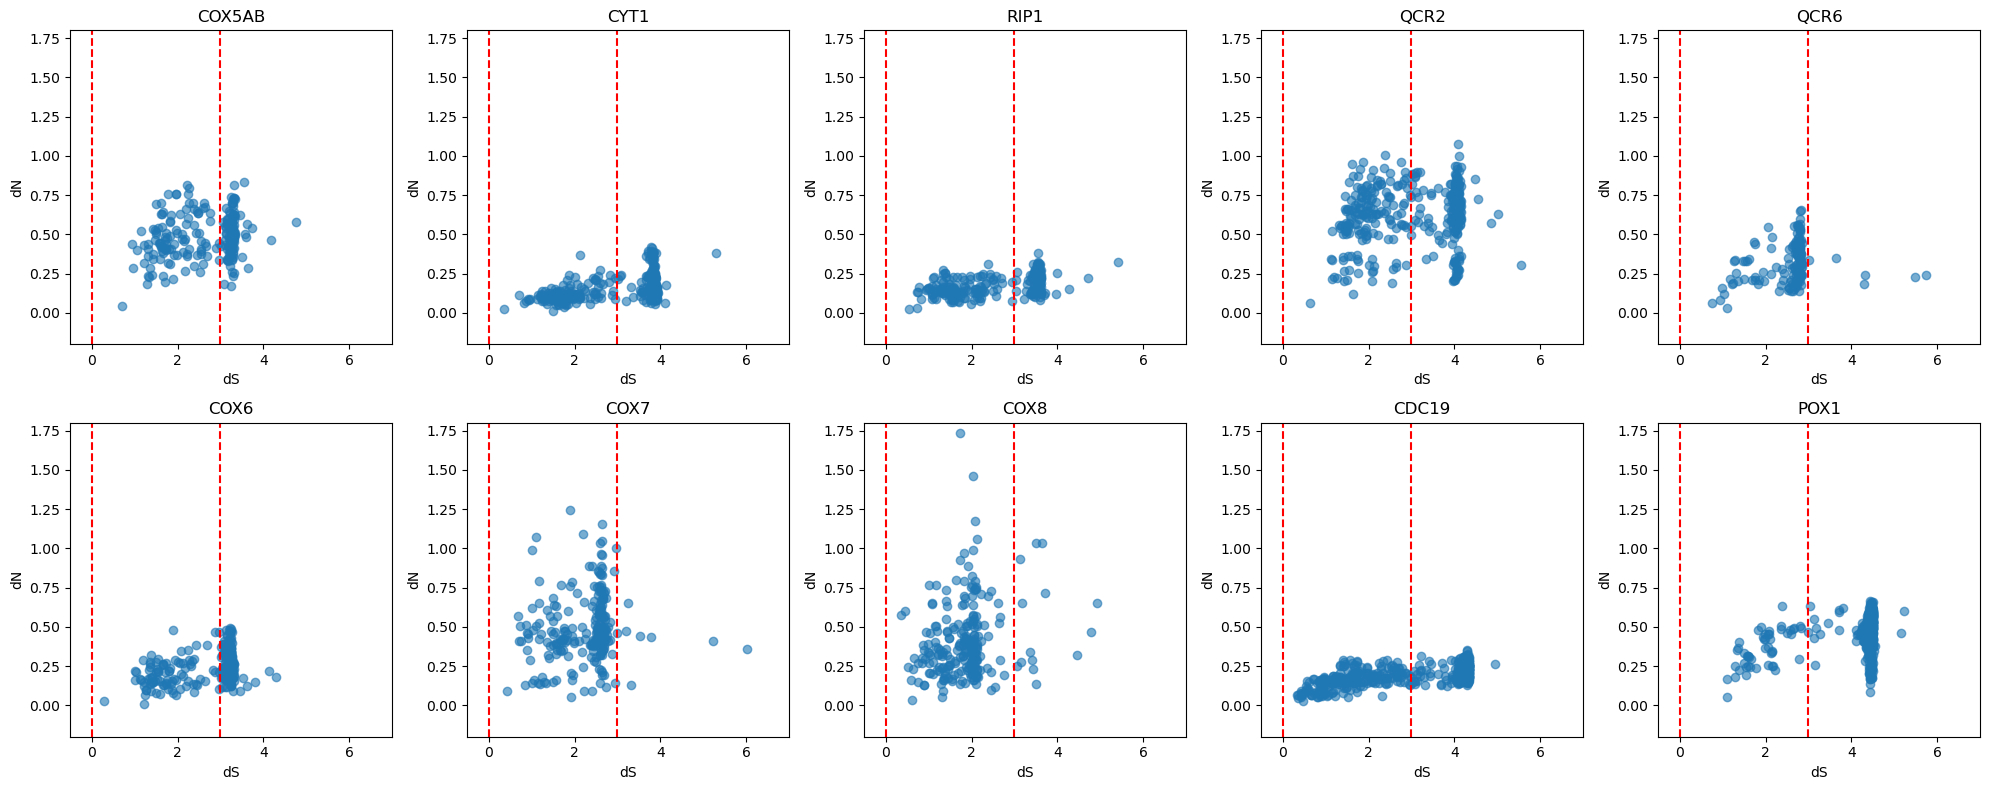

In [38]:
fig, axarr = plt.subplots(2,5, figsize = (20,8)) #, sharex=True, sharey = True)
axarr_flat = axarr.flatten()

xlim = (-0.5,7)
ylim = (-0.2, 1.8)

filter_lines = [0.005, 3.0]

for jj, (og_name, og_ref) in enumerate(example_proteins.items()):
    ax = axarr_flat[jj]

    yn00_fname = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref + '/yn00.csv')
    yn00_df = pd.read_csv(yn00_fname, index_col = 0)

    ax.scatter(yn00_df['dS_new'], yn00_df['dN_new'], alpha = 0.6)
    ax.set_title(og_name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot((filter_lines[0], filter_lines[0]),ylim,'--r')
    ax.plot((filter_lines[1], filter_lines[1]),ylim,'--r')
    
    ax.set_xlabel('dS')
    ax.set_ylabel('dN')

fig.tight_layout()

In [ ]:
# What does yn00 look like without the filter at 3? 

In [42]:
#Extract YN00 data

#Select OGS for dN/dS data

tm_align_cluster_list = []
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/fasta_renamed')): 
    tm_align_cluster_list.append(fname.split('.')[0])

tm_align_post_trim_filter_list = [] #list of og_ref names that survive the filter for 
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/cds_aln')): 
    tm_align_post_trim_filter_list.append(fname.split('.')[0])

print('OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.') 

print(set(tm_align_cluster_list) - set(tm_align_post_trim_filter_list))

selected_ogs_dict = {og_ref.split('_')[0]:og_ref for og_ref in tm_align_post_trim_filter_list}
#struct_data_dnds = struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs_dict.keys())].copy()


dN_dS_struct = []
dN_struct = []
dS_struct = []
og_list = []
og_ref_list = []

for og_ref in tm_align_post_trim_filter_list:
    og = og_ref.split('_')[0]
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref) + os.sep
    output_file = yn00_dir + 'yn00.csv'
    paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
    (dN_dS, dN, dS) = dyt.calMean_dN_dS_yn00(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS",  min_ds = 0.005, max_ds = 10.0)
    #print((dN_dS, dN, dS))
    dN_dS_struct.append(dN_dS)
    dN_struct.append(dN)
    dS_struct.append(dS)

#struct_data_dnds = pd.DataFrame.from_dict({'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct, 'og': og_list, 'og_ref': og_ref_list})

dnds_yn00 = pd.DataFrame.from_dict({'og_ref': og_ref_list,'og': og_list, 'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct})
dnds_yn00.set_index('og_ref', inplace=True)
dnds_yn00.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_maxdS_10.csv'))


OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.
{'OG1306_REF_Scer_AF-P38298-F1-model_v2', 'OG2228_geotrichum_candidum__OG2228__43_6293', 'OG1746_REF_Scer_AF-P32642-F1-model_v2'}
OG2956_REF_Scer_AF-P08456-F1-model_v2
OG3104_REF_Scer_AF-P53954-F1-model_v2
OG3242_REF_Scer_AF-P38179-F1-model_v2
OG2112_REF_Scer_AF-P33421-F1-model_v2
OG5722_geotrichum_candidum__OG5722__43_1771
OG2056_REF_Scer_AF-P20051-F1-model_v2
OG3043_REF_Scer_AF-P04161-F1-model_v2
OG2156_REF_Scer_AF-P08524-F1-model_v2
OG3112_REF_Scer_AF-Q05521-F1-model_v2
OG2357_kluyveromyces_lactis__OG2357__50_2019
OG3612_REF_Scer_AF-P18562-F1-model_v2
OG1491_REF_Scer_AF-P40506-F1-model_v2
OG3774_REF_Scer_AF-P32377-F1-model_v2
OG2746_REF_Scer_AF-P40495-F1-model_v2
OG3018_REF_Scer_AF-P38635-F1-model_v2
OG2265_REF_Scer_AF-P07286-F1-model_v2
OG3214_REF_Scer_AF-P11986-F1-model_v2
OG2262_REF_Scer_AF-P37254-F1-model_v2
OG1022_REF_Scer_AF-P4995

C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:345: UserWarning: No dN dS table in results file for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG4755_kluyveromyces_marxianus__OG4755__51_759\yn00.out
  warnings.warn('No dN dS table in results file for ' + paml_gene_dn_ds_file)


OG3509_REF_Scer_AF-P43619-F1-model_v2
OG1254_REF_Scer_AF-P40395-F1-model_v2
OG4744_REF_Scer_AF-P22289-F1-model_v2
OG2837_REF_Scer_AF-Q02196-F1-model_v2
OG2347_REF_Scer_AF-P07283-F1-model_v2
OG4346_REF_Scer_AF-P10174-F1-model_v2
OG3551_REF_Scer_AF-Q12452-F1-model_v2
OG2936_REF_Scer_AF-P00812-F1-model_v2
OG4004_REF_Scer_AF-Q12178-F1-model_v2
OG1810_kluyveromyces_lactis__OG1810__50_2108
OG1881_REF_Scer_AF-P10963-F1-model_v2
OG2740_REF_Scer_AF-P07170-F1-model_v2
OG1210_REF_Scer_AF-P38891-F1-model_v2
OG3801_REF_Scer_AF-Q12455-F1-model_v2
OG1565_REF_Scer_AF-P38604-F1-model_v2
OG2129_REF_Scer_AF-P06785-F1-model_v2
OG3676_REF_Scer_AF-P15496-F1-model_v2
OG2684_REF_Scer_AF-P41735-F1-model_v2
OG2308_REF_Scer_AF-Q07938-F1-model_v2
OG4398_REF_Scer_AF-Q04178-F1-model_v2
OG1497_REF_Scer_AF-P38143-F1-model_v2
OG1451_REF_Scer_AF-P38998-F1-model_v2
OG2183_REF_Scer_AF-P27515-F1-model_v2
OG2807_REF_Scer_AF-P16387-F1-model_v2
OG1671_REF_Scer_AF-P32861-F1-model_v2
OG1103_REF_Scer_AF-P47771-F1-model_v2
OG102

C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:345: UserWarning: No dN dS table in results file for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1054_REF_Scer_AF-P16861-F1-model_v2\yn00.out
  warnings.warn('No dN dS table in results file for ' + paml_gene_dn_ds_file)
C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:362: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 10.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1329_REF_Scer_AF-P17709-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib

OG2086_REF_Scer_AF-P80210-F1-model_v2
OG1537_REF_Scer_AF-P32288-F1-model_v2
OG1892_REF_Scer_AF-P07262-F1-model_v2
OG3336_REF_Scer_AF-P43567-F1-model_v2
OG1081_REF_Scer_AF-P32784-F1-model_v2
OG1299_REF_Scer_AF-P00549-F1-model_v2
OG1696_REF_Scer_AF-P53598-F1-model_v2
OG2603_REF_Scer_AF-P50076-F1-model_v2
OG1242_REF_Scer_AF-P36107-F1-model_v2
OG1129_REF_Scer_AF-P37303-F1-model_v2
OG4624_REF_Scer_AF-P38954-F1-model_v2
OG4231_REF_Scer_AF-P04385-F1-model_v2
OG1433_REF_Scer_AF-P40054-F1-model_v2
OG3767_REF_Scer_AF-P39683-F1-model_v2
OG1596_REF_Scer_AF-P54781-F1-model_v2
OG1087_REF_Scer_AF-P39518-F1-model_v2
OG3581_REF_Scer_AF-P41835-F1-model_v2
OG1096_REF_Scer_AF-P48570-F1-model_v2
OG1012_REF_Scer_AF-P08004-F1-model_v2
OG1357_REF_Scer_AF-P14742-F1-model_v2
OG1337_REF_Scer_AF-P32356-F1-model_v2
OG2774_REF_Scer_AF-P51601-F1-model_v2
OG1899_REF_Scer_AF-P09950-F1-model_v2
OG1753_REF_Scer_AF-Q00764-F1-model_v2
OG1004_REF_Scer_AF-P15938-F1-model_v2
OG1056_REF_Scer_AF-P21954-F1-model_v2
OG1313_REF_S

C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:362: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 10.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1060_REF_Scer_AF-P06169-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OG1115_REF_Scer_AF-P06208-F1-model_v2


C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:371: UserWarning: Omega greater than 50 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1115_REF_Scer_AF-P06208-F1-model_v2\yn00.out
  warnings.warn('Omega greater than ' + str(max_dn_ds) + ' in ' + paml_gene_dn_ds_file)


OG1758_REF_Scer_AF-Q03529-F1-model_v2
OG2455_REF_Scer_AF-P32190-F1-model_v2
OG1744_REF_Scer_AF-P32264-F1-model_v2
OG2182_REF_Scer_AF-P20485-F1-model_v2
OG1603_REF_Scer_AF-P16120-F1-model_v2


C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:362: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 10.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG1603_REF_Scer_AF-P16120-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OG1767_REF_Scer_AF-P05373-F1-model_v2
OG1273_REF_Scer_AF-P40012-F1-model_v2
OG1355_REF_Scer_AF-P10614-F1-model_v2
OG1380_REF_Scer_AF-Q07729-F1-model_v2
OG1266_REF_Scer_AF-P23337-F1-model_v2
OG2394_REF_Scer_AF-P39006-F1-model_v2
OG2028_REF_Scer_AF-P00899-F1-model_v2
OG2537_REF_Scer_AF-P11353-F1-model_v2
OG1564_REF_Scer_AF-P08019-F1-model_v2
OG2228_REF_Scer_AF-P53037-F1-model_v2
OG1264_REF_Scer_AF-P52892-F1-model_v2
OG1030_REF_Scer_AF-P37291-F1-model_v2
OG3008_REF_Scer_AF-P36076-F1-model_v2
OG2357_REF_Scer_AF-P33734-F1-model_v2
OG2382_REF_Scer_AF-P25045-F1-model_v2
OG1360_REF_Scer_AF-P12683-F1-model_v2
OG2048_REF_Scer_AF-P33412-F1-model_v2
OG1955_REF_Scer_AF-P32461-F1-model_v2
OG1640_REF_Scer_AF-P23501-F1-model_v2
OG1822_REF_Scer_AF-P43616-F1-model_v2
OG2677_REF_Scer_AF-P28834-F1-model_v2


C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:362: UserWarning: No dS values pass filters (min_ds = 0.005, max_ds = 10.0) for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2677_REF_Scer_AF-P28834-F1-model_v2\yn00.out
  warnings.warn('No dS values pass filters (min_ds = ' + str(min_ds) + ', max_ds = ' + str(max_ds) + ') for ' + paml_gene_dn_ds_file)
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bheineike\anaconda3\envs\bmh_bioinformatics\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


OG1276_REF_Scer_AF-P36013-F1-model_v2
OG1422_REF_Scer_AF-P07264-F1-model_v2
OG2227_REF_Scer_AF-P49095-F1-model_v2
OG1022_REF_Scer_AF-P38715-F1-model_v2
OG1468_REF_Scer_AF-P17898-F1-model_v2
OG1193_REF_Scer_AF-P00924-F1-model_v2
OG1502_REF_Scer_AF-P33300-F1-model_v2
OG2960_REF_Scer_AF-P16622-F1-model_v2


C:\Users\bheineike\Documents\GitHub\diverse_yeast\diverse_yeast_tools.py:345: UserWarning: No dN dS table in results file for G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\yn00\OG2960_REF_Scer_AF-P16622-F1-model_v2\yn00.out
  warnings.warn('No dN dS table in results file for ' + paml_gene_dn_ds_file)


OG2290_torulaspora_delbrueckii__OG2290__135_3975
OG1659_REF_Scer_AF-P32775-F1-model_v2
OG2999_REF_Scer_AF-P43636-F1-model_v2
OG2190_REF_Scer_AF-Q04430-F1-model_v2
OG2901_REF_Scer_AF-Q12001-F1-model_v2
OG1218_REF_Scer_AF-P08417-F1-model_v2
OG2397_REF_Scer_AF-P32796-F1-model_v2
OG1230_REF_Scer_AF-P29465-F1-model_v2
OG1788_REF_Scer_AF-P00927-F1-model_v2
OG1394_REF_Scer_AF-Q12362-F1-model_v2
OG2380_REF_Scer_AF-P53848-F1-model_v2
OG1137_REF_Scer_AF-P41911-F1-model_v2
OG1966_REF_Scer_AF-P36150-F1-model_v2
OG1977_REF_Scer_AF-P38066-F1-model_v2
OG1622_REF_Scer_AF-P15274-F1-model_v2
OG1434_REF_Scer_AF-P25340-F1-model_v2
OG1487_REF_Scer_AF-P09938-F1-model_v2
OG1170_REF_Scer_AF-P21826-F1-model_v2
OG2348_REF_Scer_AF-Q06625-F1-model_v2
OG3811_REF_Scer_AF-Q06490-F1-model_v2
OG1039_REF_Scer_AF-P19414-F1-model_v2
OG1634_REF_Scer_AF-P31688-F1-model_v2
OG1694_REF_Scer_AF-P39713-F1-model_v2
OG2123_REF_Scer_AF-P32378-F1-model_v2
OG2637_REF_Scer_AF-P80235-F1-model_v2
OG3065_REF_Scer_AF-P07285-F1-model_v2
O

In [54]:
#Load YN00 Data with filter at 10
dnds_yn00_maxdS_10 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_maxdS_10.csv'), index_col=0)

#Load original YN00 Data
dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'), index_col=0)

dnds_yn00_merged = dnds_yn00.merge(dnds_yn00_maxdS_10, left_index=True, right_index=True, how='inner', suffixes = ('_maxdS_3','_maxdS_10'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


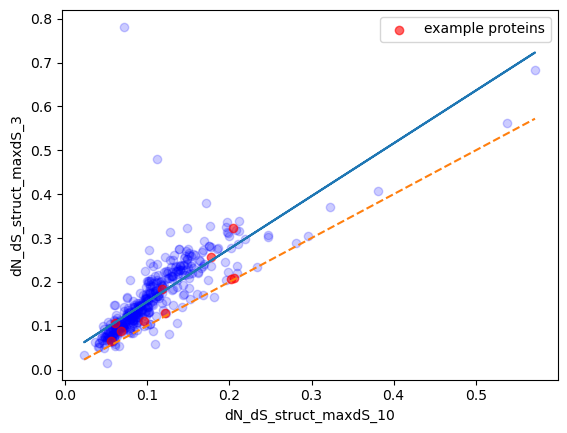

In [56]:
fig,ax = plt.subplots()

#xlim = (-0.2,1.2)

y_value = 'dN_dS_struct_maxdS_3'  #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
x_value = 'dN_dS_struct_maxdS_10' #'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

data_to_plot = dnds_yn00_merged

#dnds_foreground = (example_m0_merged.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
dnds_foreground = (data_to_plot.loc[list(example_proteins.values()), :],'r',0.6,'example proteins')
dnds_background = (data_to_plot.loc[list(set(data_to_plot.index)-set(example_proteins.values())), :], 'b', 0.2,'')

#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
#dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 

#good to quantify r2 here
for (data_to_plot_subset, color, alpha, label) in [dnds_background, dnds_foreground]:  #dnds_background, 
    ax.scatter(data_to_plot_subset[x_value], data_to_plot_subset[y_value], color = color, alpha = alpha, label=label)
    # ax.set_xlim(xlim)
    # ax.set_ylim(xlim)
    ax.set_ylabel(y_value)
    ax.set_xlabel(x_value)
    ax.legend()

#add linear regression line to scatterplot 
x_data = data_to_plot[x_value]
y_data = data_to_plot[y_value]

na_filt = x_data.notna() & y_data.notna()

x_data = x_data[na_filt]
y_data = y_data[na_filt]

#m, b = np.polyfit(x_data, y_data, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
ax.plot(list(x_data), list(slope*x_data+intercept))
ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)],'--')
#ax.plot(x_data,x_data)

In [ ]:
# How does this new YN00 look against M0 and Conservation? 

In [ ]:
#M2a vs M3 for 10 proteins

#M2a vs M3 vs Hyphy Busted for 10 proteins